# LSTM


LSTM(Long Short-Term Memory)은 **순환신경망(RNN, Recurrent Neural Network)**의 일종으로, RNN의 단점인 **장기 의존성 문제**를 해결하기 위해 고안된 신경망 구조이다.

**LSTM의 주요 특징**
1. **장기 의존성(Long-Term Dependency) 처리**
   - 일반적인 RNN은 시간이 길어질수록 과거의 정보를 잘 기억하지 못하는 **기울기 소멸(Gradient Vanishing)** 문제가 발생한다.
   - LSTM은 **Cell State**와 **게이트 구조**를 통해 중요한 정보를 장기적으로 유지할 수 있다.

2. **게이트(Gates) 구조**
   - LSTM은 정보를 선택적으로 기억하거나 잊게 해주는 3가지 게이트로 구성된다:
     - **입력 게이트(Input Gate):** 새로운 정보를 얼마나 저장할지 결정한다.
     - **망각 게이트(Forget Gate):** 기존 정보를 얼마나 잊을지 결정한다.
     - **출력 게이트(Output Gate):** 현재 상태를 출력에 얼마나 반영할지 결정한다.

3. **Cell State**
   - 네트워크의 **기억 장치** 역할을 하며, 중요하지 않은 정보는 제거하고 중요한 정보는 유지한다.


**LSTM의 구조**

![](https://d.pr/i/iPf2jG+)

아래는 LSTM의 한 타임스텝(time step)에서 이루어지는 연산 과정이다:

1. **망각 게이트 (Forget Gate)**  
    * 이전 상태 $h_{t-1}$와 입력 $x_t$를 통해 제거할 정보를 결정한다.

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

2. **입력 게이트 (Input Gate)**
    - 입력 게이트 $i_t$와 새로운 정보 $\tilde{C}_t$를 결합하여 Cell State에 반영할 정보를 생성한다.
    
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$

$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

3. **Cell State 업데이트**  
    * 이전 Cell State $C_{t-1}$와 새로운 정보의 조합으로 현재 Cell State를 업데이트한다.

$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$

    

4. **출력 게이트 (Output Gate)**  
    * 출력 게이트 $o_t$와 업데이트된 Cell State $C_t$를 통해 새로운 은닉 상태 $h_t$를 계산한다.
    
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$

$$
h_t = o_t \cdot \tanh(C_t)
$$

**LSTM의 장점**

1. **장기 시퀀스 데이터 처리**: 시간의 흐름에 따라 발생하는 데이터를 잘 학습한다.
2. **텍스트, 음성, 시계열 데이터에 적합**: 언어 모델링, 번역, 주가 예측, 음성 인식 등 다양한 분야에서 활용된다.
3. **기울기 소멸 문제 해결**: Cell State와 게이트 구조 덕분에 학습이 안정적이다.

**추가 활용**

- **양방향 LSTM (Bidirectional LSTM)**: 양방향으로 데이터를 처리하여 더 많은 정보를 학습할 수 있다.
- **Stacked LSTM**: LSTM 레이어를 여러 층 쌓아 더 복잡한 패턴을 학습한다.

## LSTM 구조

In [2]:
# LSTM 입력/출력 텐서
import torch
import torch.nn as nn

batch_size = 2     # B : 한번에 처리할 샘플(문장) 개수
seq_len = 3        # T : 시퀀스 길이(Time Steps)
input_size = 4     # F : 각 시점의 입력 차원 (vocab_size 또는 임베딩 차원)
hidden_size = 5    # H : RNN의 은닉 상태 차원

x = torch.randn(batch_size, seq_len, input_size)    # 입력 시퀀스 텐서 생성 : (B, T, F)
print(x.shape)

# LSTM 생성 ((B, T, F) 형태로 입력을 받도록 설정)
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
output, (hidden, cell) = lstm(x)    # 순전파 : output(전체 시점 출력), hidden(마지막 은닉)

print(output.shape)    # (B, T, H) : 모든 시점의 은닉 출력들이 쌓인 결과
print(hidden.shape)    # (Num_layers, B, H) : 마지막 시점 은닉 상태
print(cell.shape)      # (Num_layers, B, H) : 마지막 시점 cell state 

torch.Size([2, 3, 4])
torch.Size([2, 3, 5])
torch.Size([1, 2, 5])
torch.Size([1, 2, 5])


## IMDB 리뷰 감성분석
- IMDB 데이터는 영화 리뷰 텍스트와 그 리뷰의 감성(긍정/부정) 라벨로 구성된 이진 분류용 데이터셋
- 입력(X): 영화 리뷰 문장(원문 텍스트) → `tensorflow.keras.datasets.imdb`로 불러오면 “바로 모델에 넣어 실습할 수 있게” 미리 전처리된 형태(단어→정수 ID)로 제공
- 정답(y): 감성 라벨 0=부정, 1=긍정
- imdb.load_data(num_words=vocab_size)의 의미: 빈도 상위 vocab_size개 단어만 단어사전에 남기고, 나머지는(덜 나온 단어) 잘리거나 OOV로 처리되는 방식

- 결과적으로 **“영화 리뷰가 긍정인지 부정인지 맞추는 감성분류 데이터”**

In [ ]:
from tensorflow.keras.datasets import imdb

vocab_size = 300    # 사용할 단어 사전 크기 (빈도 상위인 단어만 유지)

# IMDB 데이터 로드 (단어 ID 시퀀스 형태)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
print(X_train.shape, y_train.shape)  # 학습 데이터 개수
print(X_test.shape, y_test.shape)    # 테스트 데이터 개수

c:\Users\Playdata\nlp\nlp_venv\Lib\site-packages\numpy\lib\_format_impl.py:838: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  array = pickle.load(fp, **pickle_kwargs)


(25000,) (25000,)
(25000,) (25000,)


### imdb 단어사전 생성 및 리뷰 디코드

In [ ]:
# 단어사전 생성
from keras.datasets import imdb

word_index = imdb.get_word_index()   # IMDB 기본 단어사전 (word -> index) 로드

pad_token = 0     # 패딩 토큰
start_char = 1    # 문장 시작 토큰
oov_char = 2      # 사전에 없는 단어 (OOV) 토큰
index_from = 2    # 실제 단어 인덱스 ~

# word_index(word->index)를 index->word 로 뒤집어서 생성
index_word = {
    index + index_from: word                  # {index + 2 : word}
    for word, index in word_index.items()     # (단어, 인덱스) 순회
    if index <= vocab_size                    # vocab_size 범위 내 단어만 사용
}
index_word[pad_token] = '[PAD]'       # 0번 토큰 : 패딩
index_word[start_char] = '[START]'    # 1번 토큰 : 시작
index_word[oov_char] = '[OOV]'        # 2번 토큰 : OOV

index_word = dict(sorted(index_word.items(), key=lambda item: item[0]))  # Key(ID) 기준 정렬

list(index_word.items())[:10]    # (ID, word) 상위 10개만 확인

[(0, '[PAD]'),
 (1, '[START]'),
 (2, '[OOV]'),
 (3, 'the'),
 (4, 'and'),
 (5, 'a'),
 (6, 'of'),
 (7, 'to'),
 (8, 'is'),
 (9, 'br')]

In [10]:
# 단어 ID 시퀀스를 텍스트 리뷰로 디코딩
decoded_review = ' '.join(index_word.get(i, "?") for i in X_train[0])
decoded_review

"[START] that on as about [OOV] [OOV] [OOV] [OOV] really [OOV] [OOV] see [OOV] and again who each a are any about [OOV] life what [OOV] [OOV] br they [OOV] everything a though and part life look [OOV] [OOV] [OOV] like and part [OOV] [OOV] for [OOV] from this [OOV] and take what as of those [OOV] movie that on and [OOV] [OOV] [OOV] and on me because i as about [OOV] from been was this [OOV] and on for [OOV] for i as [OOV] with [OOV] a which [OOV] i is [OOV] is two a and [OOV] [OOV] as [OOV] see [OOV] by and still i as from [OOV] a are off good who scene some are [OOV] by of on i come he bad more a that [OOV] as into [OOV] is and films best [OOV] was each and [OOV] to [OOV] a [OOV] who me about [OOV] [OOV] his [OOV] [OOV] has to and [OOV] [OOV] this characters how and [OOV] was american too at [OOV] no his something of enough [OOV] with and bit on film say [OOV] his [OOV] a back one [OOV] with good who he there's made are characters and bit really as from [OOV] how i as actor a as [OOV] 

정확도가 중요하면 vocab_size를 늘린다.

In [11]:
# 메모리 사용량 조절 train_size, test_size
train_size = 15000    # 학습 샘플 수
test_size = 10000     # 테스트 샘플 수
X_train = X_train[:train_size]
y_train = y_train[:train_size]
X_test = X_test[:test_size]
y_test = y_test[:test_size]

print(X_train.shape, y_train.shape)  # 학습 데이터 개수
print(X_test.shape, y_test.shape)    # 테스트 데이터 개수

(15000,) (15000,)
(10000,) (10000,)


In [12]:
# IMDB 시퀀스/라벨을 PyTorch Tensor로 변환
X_train = [torch.tensor(seq, dtype=torch.long) for seq in X_train]  # 학습 시퀀스(단어 ID 리스트) -> LongTensor로 변환
X_test = [torch.tensor(seq, dtype=torch.long) for seq in X_test]    # 테스트 시퀀스(단어 ID 리스트) -> LongTensor로 변환

y_train = torch.tensor(y_train, dtype=torch.float)    # 학습 라벨(0/1) -> FloatTensor로 변환
y_test = torch.tensor(y_test, dtype=torch.float)      # 테스트 라벨(0/1) -> FloatTensor로 변환

X_train[0], y_train[0]

(tensor([  1,  14,  22,  16,  43,   2,   2,   2,   2,  65,   2,   2,  66,   2,
           4, 173,  36, 256,   5,  25, 100,  43,   2, 112,  50,   2,   2,   9,
          35,   2, 284,   5, 150,   4, 172, 112, 167,   2,   2,   2,  39,   4,
         172,   2,   2,  17,   2,  38,  13,   2,   4, 192,  50,  16,   6, 147,
           2,  19,  14,  22,   4,   2,   2,   2,   4,  22,  71,  87,  12,  16,
          43,   2,  38,  76,  15,  13,   2,   4,  22,  17,   2,  17,  12,  16,
           2,  18,   2,   5,  62,   2,  12,   8,   2,   8, 106,   5,   4,   2,
           2,  16,   2,  66,   2,  33,   4, 130,  12,  16,  38,   2,   5,  25,
         124,  51,  36, 135,  48,  25,   2,  33,   6,  22,  12, 215,  28,  77,
          52,   5,  14,   2,  16,  82,   2,   8,   4, 107, 117,   2,  15, 256,
           4,   2,   7,   2,   5,   2,  36,  71,  43,   2,   2,  26,   2,   2,
          46,   7,   4,   2,   2,  13, 104,  88,   4,   2,  15, 297,  98,  32,
           2,  56,  26, 141,   6, 194,   2,  18,   4

In [13]:
# 시퀀스 패딩 처리로 길이 고정
import torch.nn.functional as F

seq_len = 100    # 고정할 시퀀스 길이 (패딩/자르기 기준)

# 시퀀스들을 max_len 길이로 패딩(0) 또는 자르기하여 텐서로 변환하는 함수
def pad_sequences(sequences, max_len):
    padded_sequences = []        # 패딩 완료된 시퀀스를 모을 리스트
    for seq in sequences:        # 각 샘플(가변 길이 시퀀스) 순회
        if len(seq) < max_len:
            padded_seq = F.pad(seq, (0, max_len-len(seq)), value=0)  # 오른쪽에 0을 채워 길이 맞춤
        else:
            padded_seq = seq[:max_len]    # max_len보다 길면 앞부분 남긴다.

        padded_sequences.append(padded_seq)    # 결과 시퀀스 저장
    
    return torch.stack(padded_sequences)    # 리스트를 (N, max_len) 텐서로 스택

X_train_padded = pad_sequences(X_train, seq_len)    # 학습 데이터 시퀀스 길이 고정
X_test_padded = pad_sequences(X_test, seq_len)      # 테스트 데이터 시퀀스 길이 고정

X_train_padded.shape, X_test_padded.shape    # (샘플 수, seq_len) 형태

(torch.Size([15000, 100]), torch.Size([10000, 100]))

In [14]:
# 원-핫 인코딩으로 단어 ID를 벡터로 변환
X_train_onehot = F.one_hot(X_train_padded, num_classes=vocab_size)  # (N, seq_len) ID -> (N, seq_len, vocab_size) 원-핫
X_test_onehot = F.one_hot(X_test_padded, num_classes=vocab_size)    # 테스트 데이터 동일

X_train_onehot.shape, X_test_onehot.shape

(torch.Size([15000, 100, 300]), torch.Size([10000, 100, 300]))

### One-hot + LSTM

In [15]:
# IMDB 감성분류 LSTM 모델
class SentimentNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()               # nn.Module 초기화
        self.lstm = nn.LSTM(
            input_size = input_dim,     # 입력 feature 차원 (원-핫이면 vocab_size)
            hidden_size = hidden_dim,   # 은닉 상태 차원
            batch_first = True          # 입력 shape이 (B, T, F) 형태
        )
        self.fc = nn.Linear(hidden_dim, output_dim)    # 마지막 hidden -> 출력(logit) 변환
    
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)  # output : (B, T, H), hidden/ cell : (1:layers_num, B, H)
        output = self.fc(hidden[-1])           # 마지막 레이어 hidden (B, H) -> fc 적용
        return output                          # (B, output_dim) 반환

input_dim = vocab_size    # 원-핫 인코딩 feature 차원 = vocab_size
hidden_dim = 16           # RNN 은닉차원 수
output_dim = 1            # 이진 분류 출력(logit 1개)

model = SentimentNet(input_dim, hidden_dim, output_dim)
model

SentimentNet(
  (lstm): LSTM(300, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [16]:
# RNN 모델 파라미터(가중치/편향) 이름과 shape 확인
for name, param in model.named_parameters():
    print(name, param.shape)    # 파라미터 이름과 텐서 shape 출력

lstm.weight_ih_l0 torch.Size([64, 300])
lstm.weight_hh_l0 torch.Size([64, 16])
lstm.bias_ih_l0 torch.Size([64])
lstm.bias_hh_l0 torch.Size([64])
fc.weight torch.Size([1, 16])
fc.bias torch.Size([1])


In [17]:
# torchinfo로 모델 요약(summary) 확인
from torchinfo import summary

summary(model)  # 모델 레이어별 shape/파라미터 수 요약 출력

Layer (type:depth-idx)                   Param #
SentimentNet                             --
├─LSTM: 1-1                              20,352
├─Linear: 1-2                            17
Total params: 20,369
Trainable params: 20,369
Non-trainable params: 0

fc는 보통 Fully Connected Layer(전결합층)
- self.fc = nn.Linear(hidden_dim, output_dim)
    - LSTM에서 마지막 은닉벡터(크기 hidden_dim)을 최종 출력 차원(output_dim)으로 바꿔주는 선형층

In [18]:
# 출력 라벨을 2차원 텐서로 변환
y_train = y_train.unsqueeze(1)    # (N,) -> (N, 1)로 차원 추가
y_test = y_test.unsqueeze(1)      # (N,) -> (N, 1)로 차원 추가

y_train.shape, y_test.shape

(torch.Size([15000, 1]), torch.Size([10000, 1]))

모델 출력이 (N, 1) 형태라서 라벨도 (N, 1)로 맞춰 손실계산한다.

In [ ]:
# 학습/검증/테스트 데이터 분리 및 DataLoader 구성
from torch.utils.data import random_split, DataLoader, TensorDataset

batch_size = 64                                # 미니배치 크기
train_size = int(len(X_train_onehot) * 0.8)    # 학습 데이터 개수 (80%)
val_size = len(X_train_onehot) - train_size    # 검증 데이터 개수 (20%)

# 학습/검증/테스트 데이터셋 분리
train_dataset, val_dataset = random_split(TensorDataset(X_train_onehot, y_train), [train_size, val_size])
test_dataset = TensorDataset(X_test_onehot, y_test)    # 테스트 입력/라벨을 하나의 DataSet으로 묶음

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 학습용 : 섞어서 배치 생성
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)     # 검증용 : 순서 유지
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # 테스트용 : 순서 유지

- random_split(TensorDataset(X_train_onehot, y_train), [train_size, val_size])
    - TensorDataset(X_train_onehot, y_train) : X_train_onehot[i], y_train[i]를 한쌍으로 꺼내게 해주는 Dataset (샘플단위로 묶음)
    - random_split(dataset, [train_size, val_size]) : Dataset을 인덱스를 랜덤으로 섞어서 train_size(크기) 부분 + val_size(크기) 부분으로 나눔.
        - 반환값은 (train_dataset, val_dataset) 두개의 Subset 객체
    - 결과적으로는 (X, y) 쌍으로 묶인 학습 데이터를 무작위로 "train, val" 덩어리로 나눈다.

In [20]:
from tqdm import tqdm
import torch.optim as optim

# GPU 활용 가능시 GPU 기반으로 RNN 학습 루프 (BCEWithLogits + Adam + Early Stopping)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

# 메모리 캐시 정리
torch.cuda.empty_cache()

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()                       # 이진분류 손실 (시그모이드 포함 logit 입력용)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 100

# 시각화를 위한 loss 기록
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련
early_stopping_patience = 20
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in tqdm(range(epochs)):
    total_loss, correct, total = 0, 0, 0    # 누적 손실, 정답, 전체 샘플 수

    model.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()

        optimizer.zero_grad()               # 이전 배치 기울기 초기화
        output = model(inputs)              # 순전파
        loss = criterion(output, labels)    # 손실 계산
        loss.backward()                     # 역전파
        optimizer.step()                    # 파라미터 업데이트

        # 배치 로그
        total_loss += loss.item()    # 배치 손실을 스칼라로 누적
        p = torch.sigmoid(output)    # logit -> 0~1 확률로 변환
        pred = (p >= 0.5).float()
        correct += (pred == labels).sum().item()  # 맞춘 개수
        total += labels.size(0)                   # 배치 샘플 수
    
    # 에폭 로그
    train_loss = total_loss / len(train_dataloader)  # 에폭별 평균 학습 손실
    train_losses.append(train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)

    # 검증
    model.eval()                                # 평가 모드 (Dropout, BN 비활성화)
    val_loss, val_correct, val_total = 0, 0, 0  # 누적 손실, 정답, 전체 샘플 수
    with torch.no_grad():                       # 기울기 계산 비활성화
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device).float(), val_labels.to(device).float()
        
            output = model(val_inputs)
            loss = criterion(output, val_labels)
            
            # 배치 로그
            val_loss += loss.item()
            p = torch.sigmoid(output)
            pred = (p >= 0.5).float()
            val_correct += (pred == val_labels).sum().item()
            val_total += val_labels.size(0)
        
        # 에폭 로그
        val_loss = val_loss / len(val_dataloader)
        val_losses.append(val_loss)
        val_acc = val_correct / val_total
        val_accs.append(val_acc)

        # 에폭 로그 출력
        print(f"Epoch {epoch +1}/{epochs}: Train Loss {train_loss:.4f} Train Acc {train_acc:.4f} Val loss {val_loss:.4f} Val Acc {val_acc:.4f}")

        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopped at Epoch {epoch +1}")
                break

device cpu


  1%|          | 1/100 [00:03<05:55,  3.59s/it]

Epoch 1/100: Train Loss 0.6939 Train Acc 0.5031 Val loss 0.6942 Val Acc 0.4993


  2%|▏         | 2/100 [00:07<06:29,  3.98s/it]

Epoch 2/100: Train Loss 0.6934 Train Acc 0.5041 Val loss 0.6938 Val Acc 0.4980


  3%|▎         | 3/100 [00:11<05:50,  3.62s/it]

Epoch 3/100: Train Loss 0.6931 Train Acc 0.5068 Val loss 0.6935 Val Acc 0.5033


  4%|▍         | 4/100 [00:14<05:40,  3.55s/it]

Epoch 4/100: Train Loss 0.6929 Train Acc 0.5145 Val loss 0.6932 Val Acc 0.5100


  5%|▌         | 5/100 [00:17<05:29,  3.47s/it]

Epoch 5/100: Train Loss 0.6926 Train Acc 0.5198 Val loss 0.6929 Val Acc 0.5090


  6%|▌         | 6/100 [00:21<05:45,  3.68s/it]

Epoch 6/100: Train Loss 0.6924 Train Acc 0.5287 Val loss 0.6927 Val Acc 0.5107


  7%|▋         | 7/100 [00:26<05:56,  3.84s/it]

Epoch 7/100: Train Loss 0.6921 Train Acc 0.5335 Val loss 0.6923 Val Acc 0.5117


  8%|▊         | 8/100 [00:29<05:51,  3.83s/it]

Epoch 8/100: Train Loss 0.6918 Train Acc 0.5398 Val loss 0.6919 Val Acc 0.5243


  9%|▉         | 9/100 [00:33<05:50,  3.85s/it]

Epoch 9/100: Train Loss 0.6914 Train Acc 0.5397 Val loss 0.6914 Val Acc 0.5323


 10%|█         | 10/100 [00:38<05:59,  3.99s/it]

Epoch 10/100: Train Loss 0.6908 Train Acc 0.5447 Val loss 0.6907 Val Acc 0.5447


 11%|█         | 11/100 [00:42<05:55,  3.99s/it]

Epoch 11/100: Train Loss 0.6900 Train Acc 0.5441 Val loss 0.6897 Val Acc 0.5460


 12%|█▏        | 12/100 [00:45<05:42,  3.90s/it]

Epoch 12/100: Train Loss 0.6884 Train Acc 0.5510 Val loss 0.6855 Val Acc 0.5500


 13%|█▎        | 13/100 [00:49<05:28,  3.78s/it]

Epoch 13/100: Train Loss 0.6736 Train Acc 0.5978 Val loss 0.6626 Val Acc 0.6277


 14%|█▍        | 14/100 [00:52<05:18,  3.71s/it]

Epoch 14/100: Train Loss 0.6608 Train Acc 0.6250 Val loss 0.6583 Val Acc 0.6350


 15%|█▌        | 15/100 [00:56<05:03,  3.57s/it]

Epoch 15/100: Train Loss 0.6536 Train Acc 0.6348 Val loss 0.6488 Val Acc 0.6363


 16%|█▌        | 16/100 [00:59<04:56,  3.53s/it]

Epoch 16/100: Train Loss 0.6468 Train Acc 0.6476 Val loss 0.6460 Val Acc 0.6423


 17%|█▋        | 17/100 [01:02<04:52,  3.52s/it]

Epoch 17/100: Train Loss 0.6420 Train Acc 0.6563 Val loss 0.6411 Val Acc 0.6463


 18%|█▊        | 18/100 [01:06<04:49,  3.53s/it]

Epoch 18/100: Train Loss 0.6412 Train Acc 0.6526 Val loss 0.6380 Val Acc 0.6490


 19%|█▉        | 19/100 [01:09<04:44,  3.51s/it]

Epoch 19/100: Train Loss 0.6374 Train Acc 0.6562 Val loss 0.6382 Val Acc 0.6630


 20%|██        | 20/100 [01:13<04:36,  3.45s/it]

Epoch 20/100: Train Loss 0.6318 Train Acc 0.6665 Val loss 0.6343 Val Acc 0.6613


 21%|██        | 21/100 [01:16<04:30,  3.43s/it]

Epoch 21/100: Train Loss 0.6269 Train Acc 0.6725 Val loss 0.6314 Val Acc 0.6570


 22%|██▏       | 22/100 [01:19<04:24,  3.39s/it]

Epoch 22/100: Train Loss 0.6309 Train Acc 0.6703 Val loss 0.6302 Val Acc 0.6567


 23%|██▎       | 23/100 [01:23<04:23,  3.42s/it]

Epoch 23/100: Train Loss 0.6254 Train Acc 0.6735 Val loss 0.6288 Val Acc 0.6633


 24%|██▍       | 24/100 [01:26<04:19,  3.41s/it]

Epoch 24/100: Train Loss 0.6230 Train Acc 0.6767 Val loss 0.6261 Val Acc 0.6633


 25%|██▌       | 25/100 [01:30<04:16,  3.41s/it]

Epoch 25/100: Train Loss 0.6167 Train Acc 0.6839 Val loss 0.6241 Val Acc 0.6727


 26%|██▌       | 26/100 [01:33<04:09,  3.37s/it]

Epoch 26/100: Train Loss 0.6139 Train Acc 0.6865 Val loss 0.6208 Val Acc 0.6703


 27%|██▋       | 27/100 [01:36<04:05,  3.36s/it]

Epoch 27/100: Train Loss 0.6106 Train Acc 0.6891 Val loss 0.6194 Val Acc 0.6783


 28%|██▊       | 28/100 [01:40<04:02,  3.37s/it]

Epoch 28/100: Train Loss 0.6073 Train Acc 0.6918 Val loss 0.6197 Val Acc 0.6780


 29%|██▉       | 29/100 [01:43<03:57,  3.35s/it]

Epoch 29/100: Train Loss 0.6048 Train Acc 0.6953 Val loss 0.6160 Val Acc 0.6780


 30%|███       | 30/100 [01:46<03:53,  3.34s/it]

Epoch 30/100: Train Loss 0.6111 Train Acc 0.6806 Val loss 0.6525 Val Acc 0.6670


 31%|███       | 31/100 [01:50<03:49,  3.33s/it]

Epoch 31/100: Train Loss 0.6116 Train Acc 0.6903 Val loss 0.6158 Val Acc 0.6710


 32%|███▏      | 32/100 [01:53<03:43,  3.29s/it]

Epoch 32/100: Train Loss 0.5992 Train Acc 0.6983 Val loss 0.6160 Val Acc 0.6837


 33%|███▎      | 33/100 [01:56<03:39,  3.27s/it]

Epoch 33/100: Train Loss 0.5971 Train Acc 0.6997 Val loss 0.6132 Val Acc 0.6793


 34%|███▍      | 34/100 [01:59<03:33,  3.24s/it]

Epoch 34/100: Train Loss 0.5955 Train Acc 0.7027 Val loss 0.6133 Val Acc 0.6857


 35%|███▌      | 35/100 [02:03<03:29,  3.23s/it]

Epoch 35/100: Train Loss 0.5929 Train Acc 0.7058 Val loss 0.6122 Val Acc 0.6863


 36%|███▌      | 36/100 [02:06<03:25,  3.22s/it]

Epoch 36/100: Train Loss 0.5921 Train Acc 0.7067 Val loss 0.6117 Val Acc 0.6860


 37%|███▋      | 37/100 [02:09<03:24,  3.25s/it]

Epoch 37/100: Train Loss 0.5900 Train Acc 0.7083 Val loss 0.6105 Val Acc 0.6880


 38%|███▊      | 38/100 [02:12<03:23,  3.27s/it]

Epoch 38/100: Train Loss 0.5979 Train Acc 0.7024 Val loss 0.6086 Val Acc 0.6857


 39%|███▉      | 39/100 [02:16<03:19,  3.27s/it]

Epoch 39/100: Train Loss 0.6003 Train Acc 0.6873 Val loss 0.6085 Val Acc 0.6863


 40%|████      | 40/100 [02:19<03:12,  3.21s/it]

Epoch 40/100: Train Loss 0.5855 Train Acc 0.7112 Val loss 0.6060 Val Acc 0.6883


 41%|████      | 41/100 [02:22<03:08,  3.20s/it]

Epoch 41/100: Train Loss 0.5846 Train Acc 0.7138 Val loss 0.6067 Val Acc 0.6857


 42%|████▏     | 42/100 [02:25<03:06,  3.21s/it]

Epoch 42/100: Train Loss 0.5923 Train Acc 0.7067 Val loss 0.6048 Val Acc 0.6823


 43%|████▎     | 43/100 [02:28<03:02,  3.20s/it]

Epoch 43/100: Train Loss 0.6596 Train Acc 0.6691 Val loss 0.6374 Val Acc 0.6800


 44%|████▍     | 44/100 [02:32<03:02,  3.25s/it]

Epoch 44/100: Train Loss 0.5931 Train Acc 0.7037 Val loss 0.6133 Val Acc 0.6793


 45%|████▌     | 45/100 [02:35<02:59,  3.27s/it]

Epoch 45/100: Train Loss 0.5867 Train Acc 0.7077 Val loss 0.6109 Val Acc 0.6830


 46%|████▌     | 46/100 [02:38<02:57,  3.28s/it]

Epoch 46/100: Train Loss 0.5869 Train Acc 0.7049 Val loss 0.6082 Val Acc 0.6873


 47%|████▋     | 47/100 [02:41<02:52,  3.25s/it]

Epoch 47/100: Train Loss 0.5869 Train Acc 0.7085 Val loss 0.6073 Val Acc 0.6920


 48%|████▊     | 48/100 [02:45<02:48,  3.24s/it]

Epoch 48/100: Train Loss 0.5839 Train Acc 0.7106 Val loss 0.6074 Val Acc 0.6847


 49%|████▉     | 49/100 [02:48<02:45,  3.24s/it]

Epoch 49/100: Train Loss 0.5817 Train Acc 0.7142 Val loss 0.6056 Val Acc 0.6970


 50%|█████     | 50/100 [02:51<02:42,  3.25s/it]

Epoch 50/100: Train Loss 0.5794 Train Acc 0.7173 Val loss 0.6062 Val Acc 0.6873


 51%|█████     | 51/100 [02:54<02:40,  3.27s/it]

Epoch 51/100: Train Loss 0.5775 Train Acc 0.7174 Val loss 0.6048 Val Acc 0.6897


 52%|█████▏    | 52/100 [02:58<02:37,  3.27s/it]

Epoch 52/100: Train Loss 0.5766 Train Acc 0.7195 Val loss 0.6042 Val Acc 0.6923


 53%|█████▎    | 53/100 [03:01<02:32,  3.24s/it]

Epoch 53/100: Train Loss 0.5784 Train Acc 0.7170 Val loss 0.6096 Val Acc 0.6937


 54%|█████▍    | 54/100 [03:04<02:30,  3.28s/it]

Epoch 54/100: Train Loss 0.5763 Train Acc 0.7192 Val loss 0.6035 Val Acc 0.6917


 55%|█████▌    | 55/100 [03:08<02:27,  3.29s/it]

Epoch 55/100: Train Loss 0.5734 Train Acc 0.7225 Val loss 0.6030 Val Acc 0.6913


 56%|█████▌    | 56/100 [03:11<02:23,  3.27s/it]

Epoch 56/100: Train Loss 0.5729 Train Acc 0.7225 Val loss 0.6041 Val Acc 0.6893


 57%|█████▋    | 57/100 [03:14<02:20,  3.27s/it]

Epoch 57/100: Train Loss 0.5721 Train Acc 0.7234 Val loss 0.6034 Val Acc 0.6910


 58%|█████▊    | 58/100 [03:17<02:17,  3.28s/it]

Epoch 58/100: Train Loss 0.5709 Train Acc 0.7235 Val loss 0.6041 Val Acc 0.6890


 59%|█████▉    | 59/100 [03:21<02:14,  3.29s/it]

Epoch 59/100: Train Loss 0.5707 Train Acc 0.7241 Val loss 0.6029 Val Acc 0.6920


 60%|██████    | 60/100 [03:24<02:12,  3.32s/it]

Epoch 60/100: Train Loss 0.5692 Train Acc 0.7242 Val loss 0.6011 Val Acc 0.6957


 61%|██████    | 61/100 [03:27<02:09,  3.33s/it]

Epoch 61/100: Train Loss 0.5689 Train Acc 0.7260 Val loss 0.6041 Val Acc 0.6897


 62%|██████▏   | 62/100 [03:31<02:07,  3.36s/it]

Epoch 62/100: Train Loss 0.5671 Train Acc 0.7263 Val loss 0.5994 Val Acc 0.6950


 63%|██████▎   | 63/100 [03:34<02:04,  3.35s/it]

Epoch 63/100: Train Loss 0.5658 Train Acc 0.7282 Val loss 0.6007 Val Acc 0.6973


 64%|██████▍   | 64/100 [03:37<01:59,  3.33s/it]

Epoch 64/100: Train Loss 0.5661 Train Acc 0.7272 Val loss 0.5990 Val Acc 0.6967


 65%|██████▌   | 65/100 [03:41<01:56,  3.33s/it]

Epoch 65/100: Train Loss 0.5655 Train Acc 0.7274 Val loss 0.6037 Val Acc 0.6927


 66%|██████▌   | 66/100 [03:44<01:53,  3.33s/it]

Epoch 66/100: Train Loss 0.5657 Train Acc 0.7276 Val loss 0.5987 Val Acc 0.6947


 67%|██████▋   | 67/100 [03:47<01:49,  3.32s/it]

Epoch 67/100: Train Loss 0.5709 Train Acc 0.7253 Val loss 0.5990 Val Acc 0.6970


 68%|██████▊   | 68/100 [03:51<01:47,  3.37s/it]

Epoch 68/100: Train Loss 0.5642 Train Acc 0.7285 Val loss 0.6001 Val Acc 0.6943


 69%|██████▉   | 69/100 [03:55<01:47,  3.47s/it]

Epoch 69/100: Train Loss 0.5616 Train Acc 0.7301 Val loss 0.6008 Val Acc 0.6933


 70%|███████   | 70/100 [03:58<01:42,  3.41s/it]

Epoch 70/100: Train Loss 0.5703 Train Acc 0.7230 Val loss 0.5994 Val Acc 0.6933


 71%|███████   | 71/100 [04:01<01:39,  3.43s/it]

Epoch 71/100: Train Loss 0.5617 Train Acc 0.7312 Val loss 0.5988 Val Acc 0.6957


 72%|███████▏  | 72/100 [04:05<01:35,  3.40s/it]

Epoch 72/100: Train Loss 0.5605 Train Acc 0.7312 Val loss 0.5973 Val Acc 0.6980


 73%|███████▎  | 73/100 [04:08<01:30,  3.34s/it]

Epoch 73/100: Train Loss 0.5717 Train Acc 0.7164 Val loss 0.5973 Val Acc 0.6920


 74%|███████▍  | 74/100 [04:11<01:25,  3.27s/it]

Epoch 74/100: Train Loss 0.5608 Train Acc 0.7325 Val loss 0.5981 Val Acc 0.6990


 75%|███████▌  | 75/100 [04:14<01:22,  3.30s/it]

Epoch 75/100: Train Loss 0.6066 Train Acc 0.6994 Val loss 0.5937 Val Acc 0.7020


 76%|███████▌  | 76/100 [04:18<01:18,  3.27s/it]

Epoch 76/100: Train Loss 0.5611 Train Acc 0.7322 Val loss 0.5954 Val Acc 0.6973


 77%|███████▋  | 77/100 [04:21<01:14,  3.26s/it]

Epoch 77/100: Train Loss 0.5588 Train Acc 0.7334 Val loss 0.5951 Val Acc 0.6993


 78%|███████▊  | 78/100 [04:24<01:11,  3.24s/it]

Epoch 78/100: Train Loss 0.5582 Train Acc 0.7334 Val loss 0.5948 Val Acc 0.6997


 79%|███████▉  | 79/100 [04:27<01:08,  3.26s/it]

Epoch 79/100: Train Loss 0.5579 Train Acc 0.7324 Val loss 0.5954 Val Acc 0.6983


 80%|████████  | 80/100 [04:31<01:06,  3.32s/it]

Epoch 80/100: Train Loss 0.5562 Train Acc 0.7353 Val loss 0.5954 Val Acc 0.7003


 81%|████████  | 81/100 [04:34<01:02,  3.27s/it]

Epoch 81/100: Train Loss 0.5560 Train Acc 0.7346 Val loss 0.5951 Val Acc 0.7013


 82%|████████▏ | 82/100 [04:37<00:59,  3.29s/it]

Epoch 82/100: Train Loss 0.5616 Train Acc 0.7268 Val loss 0.5928 Val Acc 0.6977


 83%|████████▎ | 83/100 [04:41<00:56,  3.30s/it]

Epoch 83/100: Train Loss 0.5560 Train Acc 0.7349 Val loss 0.5909 Val Acc 0.7027


 84%|████████▍ | 84/100 [04:44<00:51,  3.25s/it]

Epoch 84/100: Train Loss 0.5548 Train Acc 0.7356 Val loss 0.5965 Val Acc 0.7027


 85%|████████▌ | 85/100 [04:47<00:49,  3.28s/it]

Epoch 85/100: Train Loss 0.5535 Train Acc 0.7365 Val loss 0.5925 Val Acc 0.7007


 86%|████████▌ | 86/100 [04:51<00:46,  3.35s/it]

Epoch 86/100: Train Loss 0.5650 Train Acc 0.7225 Val loss 0.5906 Val Acc 0.7013


 87%|████████▋ | 87/100 [04:54<00:43,  3.33s/it]

Epoch 87/100: Train Loss 0.5534 Train Acc 0.7358 Val loss 0.5922 Val Acc 0.7023


 88%|████████▊ | 88/100 [04:57<00:39,  3.25s/it]

Epoch 88/100: Train Loss 0.5530 Train Acc 0.7358 Val loss 0.5903 Val Acc 0.7000


 89%|████████▉ | 89/100 [05:00<00:36,  3.30s/it]

Epoch 89/100: Train Loss 0.5530 Train Acc 0.7369 Val loss 0.5947 Val Acc 0.6963


 90%|█████████ | 90/100 [05:03<00:32,  3.25s/it]

Epoch 90/100: Train Loss 0.5512 Train Acc 0.7387 Val loss 0.5919 Val Acc 0.7037


 91%|█████████ | 91/100 [05:07<00:29,  3.33s/it]

Epoch 91/100: Train Loss 0.5527 Train Acc 0.7359 Val loss 0.5930 Val Acc 0.7040


 92%|█████████▏| 92/100 [05:10<00:26,  3.29s/it]

Epoch 92/100: Train Loss 0.5516 Train Acc 0.7353 Val loss 0.5884 Val Acc 0.7040


 93%|█████████▎| 93/100 [05:14<00:23,  3.41s/it]

Epoch 93/100: Train Loss 0.5515 Train Acc 0.7387 Val loss 0.5868 Val Acc 0.7027


 94%|█████████▍| 94/100 [05:17<00:20,  3.37s/it]

Epoch 94/100: Train Loss 0.5487 Train Acc 0.7398 Val loss 0.5925 Val Acc 0.7013


 95%|█████████▌| 95/100 [05:21<00:17,  3.47s/it]

Epoch 95/100: Train Loss 0.5537 Train Acc 0.7358 Val loss 0.5842 Val Acc 0.7047


 96%|█████████▌| 96/100 [05:24<00:14,  3.50s/it]

Epoch 96/100: Train Loss 0.6553 Train Acc 0.6281 Val loss 0.6332 Val Acc 0.6380


 97%|█████████▋| 97/100 [05:28<00:10,  3.51s/it]

Epoch 97/100: Train Loss 0.5688 Train Acc 0.7135 Val loss 0.5884 Val Acc 0.7083


 98%|█████████▊| 98/100 [05:32<00:07,  3.62s/it]

Epoch 98/100: Train Loss 0.5500 Train Acc 0.7368 Val loss 0.5824 Val Acc 0.7110


 99%|█████████▉| 99/100 [05:36<00:03,  3.65s/it]

Epoch 99/100: Train Loss 0.5499 Train Acc 0.7372 Val loss 0.5911 Val Acc 0.7070


100%|██████████| 100/100 [05:39<00:00,  3.39s/it]

Epoch 100/100: Train Loss 0.5474 Train Acc 0.7389 Val loss 0.5809 Val Acc 0.7100


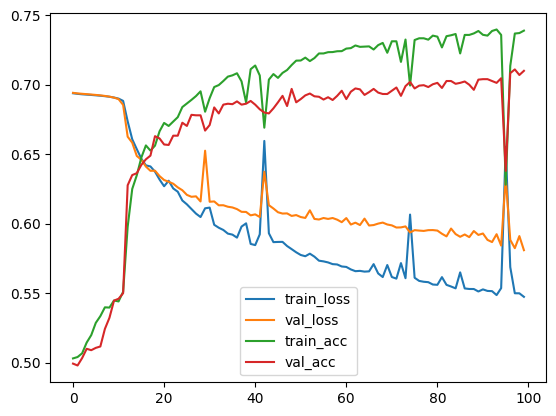

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})

df.plot()     # DataFrame 컬럼들을 한번에 라인 플롯으로 시각화
plt.show()

### Embedding + LSTM

In [27]:
# IMDB 감성분류 LSTM 모델 : 단어 ID 시퀀스를 Embedding으로 변환한 뒤 LSTM을 거쳐 감성 점수(logit)을 출력하는 모델
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()              # nn.Module 초기화

        self.embedding = nn.Embedding(        # 단어 ID -> 임베딩 벡터로 변환
            num_embeddings = vocab_size,      # 단어 사전 크기
            embedding_dim = embedding_dim,    # 임베딩 차원 (각 차원을 embedding_dim 벡터로 표현)
            padding_idx = 0                   # PAD(0) 토큰 임베딩은 업데이트 하지 않는다.
        )

        self.lstm = nn.LSTM(
            input_size = embedding_dim, # 입력 feature 차원
            hidden_size = hidden_dim,   # 은닉 상태 차원
            batch_first = True          # 입력 shape이 (B, T, F) 형태
        )
        self.fc = nn.Linear(hidden_dim, output_dim)    # 마지막 hidden -> 출력(logit) 변환
    
    def forward(self, x):
        x = self.embedding(x)                  # (B, T) -> (B, T, E) 임베딩 변환
        output, (hidden, cell) = self.lstm(x)  # output : (B, T, H), hidden/ cell : (1:layers_num, B, H)
        output = self.fc(hidden[-1])           # 마지막 레이어 hidden (B, H) -> fc 적용
        return output                          # (B, output_dim) 반환

embedding_dim = 50        # 임베딩 벡터 차원
hidden_dim = 16           # RNN 은닉차원 수
output_dim = 1            # 이진 분류 출력(logit 1개)

model = SentimentNet(vocab_size, embedding_dim, hidden_dim, output_dim)
model

SentimentNet(
  (embedding): Embedding(300, 50, padding_idx=0)
  (lstm): LSTM(50, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [28]:
# RNN 모델 파라미터(가중치/편향) 이름과 shape 확인
for name, param in model.named_parameters():
    print(name, param.shape)    # 파라미터 이름과 텐서 shape 출력

embedding.weight torch.Size([300, 50])
lstm.weight_ih_l0 torch.Size([64, 50])
lstm.weight_hh_l0 torch.Size([64, 16])
lstm.bias_ih_l0 torch.Size([64])
lstm.bias_hh_l0 torch.Size([64])
fc.weight torch.Size([1, 16])
fc.bias torch.Size([1])


In [29]:
# torchinfo로 모델 요약(summary) 확인
from torchinfo import summary

summary(model)  # 모델 레이어별 shape/파라미터 수 요약 출력

Layer (type:depth-idx)                   Param #
SentimentNet                             --
├─Embedding: 1-1                         15,000
├─LSTM: 1-2                              4,352
├─Linear: 1-3                            17
Total params: 19,369
Trainable params: 19,369
Non-trainable params: 0

In [25]:
### Embedding + LSTM(num_layers)

In [26]:
# LSTM 입력/출력 텐서
import torch
import torch.nn as nn

batch_size = 2     # B : 한번에 처리할 샘플(문장) 개수
seq_len = 3        # T : 시퀀스 길이(Time Steps)
input_size = 4     # F : 각 시점의 입력 차원 (vocab_size 또는 임베딩 차원)
hidden_size = 5    # H : RNN의 은닉 상태 차원

x = torch.randn(batch_size, seq_len, input_size)    # 입력 시퀀스 텐서 생성 : (B, T, F)
print(x.shape)

# LSTM 생성 ((B, T, F) 형태로 입력을 받도록 설정)
lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)    # 2층 LSTM 생성
output, (hidden, cell) = lstm(x)    # 순전파 : output(전체 시점 출력), hidden(마지막 은닉)

print(output.shape)    # (B, T, H) : 모든 시점의 은닉 출력들이 쌓인 결과
print(hidden.shape)    # (Num_layers, B, H) : 마지막 시점 은닉 상태
print(cell.shape)      # (Num_layers, B, H) : 마지막 시점 cell state 

torch.Size([2, 3, 4])
torch.Size([2, 3, 5])
torch.Size([2, 2, 5])
torch.Size([2, 2, 5])


In [30]:
# IMDB 감성분류 LSTM 모델 : 단어 ID 시퀀스를 Embedding으로 변환한 뒤 LSTM을 거쳐 감성 점수(logit)을 출력하는 모델 (2-layer LSTM)
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super().__init__()              # nn.Module 초기화

        self.embedding = nn.Embedding(        # 단어 ID -> 임베딩 벡터로 변환
            num_embeddings = vocab_size,      # 단어 사전 크기
            embedding_dim = embedding_dim,    # 임베딩 차원 (각 차원을 embedding_dim 벡터로 표현)
            padding_idx = 0                   # PAD(0) 토큰 임베딩은 업데이트 하지 않는다.
        )

        self.lstm = nn.LSTM(
            input_size = embedding_dim,  # 입력 feature 차원
            hidden_size = hidden_dim,    # 은닉 상태 차원
            batch_first = True,          # 입력 shape이 (B, T, F) 형태
            num_layers = num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)    # 마지막 hidden -> 출력(logit) 변환
    
    def forward(self, x):
        x = self.embedding(x)                  # (B, T) -> (B, T, E) 임베딩 변환
        output, (hidden, cell) = self.lstm(x)  # output : (B, T, H), hidden/ cell : (L:layers_num, B, H)
        output = self.fc(hidden[-1])           # 마지막 레이어 hidden (B, H) -> fc 적용
        return output                          # (B, output_dim) 반환

embedding_dim = 50        # 임베딩 벡터 차원
hidden_dim = 16           # RNN 은닉차원 수
output_dim = 1            # 이진 분류 출력(logit 1개)

model = SentimentNet(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2)
model

SentimentNet(
  (embedding): Embedding(300, 50, padding_idx=0)
  (lstm): LSTM(50, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [31]:
# RNN 모델 파라미터(가중치/편향) 이름과 shape 확인
for name, param in model.named_parameters():
    print(name, param.shape)    # 파라미터 이름과 텐서 shape 출력

embedding.weight torch.Size([300, 50])
lstm.weight_ih_l0 torch.Size([64, 50])
lstm.weight_hh_l0 torch.Size([64, 16])
lstm.bias_ih_l0 torch.Size([64])
lstm.bias_hh_l0 torch.Size([64])
lstm.weight_ih_l1 torch.Size([64, 16])
lstm.weight_hh_l1 torch.Size([64, 16])
lstm.bias_ih_l1 torch.Size([64])
lstm.bias_hh_l1 torch.Size([64])
fc.weight torch.Size([1, 16])
fc.bias torch.Size([1])


In [32]:
# torchinfo로 모델 요약(summary) 확인
from torchinfo import summary

summary(model)  # 모델 레이어별 shape/파라미터 수 요약 출력

Layer (type:depth-idx)                   Param #
SentimentNet                             --
├─Embedding: 1-1                         15,000
├─LSTM: 1-2                              6,528
├─Linear: 1-3                            17
Total params: 21,545
Trainable params: 21,545
Non-trainable params: 0

파라미터 수에 따른 학습시간 계산에 사용한다. (x 데이터량)

### Emebedding + LSTM(bidirectional)

![](https://d.pr/i/0u69xz+)


**Bidirectional LSTM**은 LSTM의 변형 모델로, **양방향으로 데이터를 처리**할 수 있도록 설계된 구조이다. 일반 LSTM이 입력 데이터를 **순방향(forward)**으로만 처리하는 반면, Bidirectional LSTM은 **순방향**과 **역방향(backward)**으로 데이터를 동시에 처리하여 더 많은 정보를 학습한다.


1. **양방향 정보 학습**  
   - 순방향 LSTM은 이전 시점의 정보만을 사용하여 다음 시점의 출력을 계산한다.
   - Bidirectional LSTM은 데이터의 시간적 흐름을 순방향과 역방향으로 모두 고려하여 **이전**과 **이후**의 정보를 동시에 학습한다.

2. **문맥 정보 강화**  
   - 예를 들어, 텍스트 데이터를 처리할 때 문장의 맥락(Context)을 양방향으로 학습하여 더 정확한 결과를 얻을 수 있다.  
    - 예: "He went to the bank ..."에서 "bank"가 "은행"인지 "강둑"인지 구분하기 위해 이후 단어의 정보를 활용할 수 있다.
    - Forward LSTM:
    ```He → went → to → the → bank → to → withdraw → money```
    - Backward LSTM:
    ```money → withdraw → to → bank → the → to → went → He```


In [34]:
# LSTM 입력/출력 텐서
import torch
import torch.nn as nn

batch_size = 2     # B : 한번에 처리할 샘플(문장) 개수
seq_len = 3        # T : 시퀀스 길이(Time Steps)
input_size = 4     # F : 각 시점의 입력 차원 (vocab_size 또는 임베딩 차원)
hidden_size = 5    # H : RNN의 은닉 상태 차원

x = torch.randn(batch_size, seq_len, input_size)    # 입력 시퀀스 텐서 생성 : (B, T, F)
print(x.shape)

# LSTM 생성 ((B, T, F) 형태로 입력을 받도록 설정)
lstm = nn.LSTM(
    input_size,           # 입력 feature 차원 F : 각 시점에 들어오는 벡터 크기
    hidden_size,          # 은닉 상태 차원 H : LSTM hidden/cell state 크기
    batch_first=True,     # 입력/출력 텐서 shape을 (B, T, F)로 사용 (False : T, B, F 순으로 사용)
    num_layers=1,         # LSTM을 몇 층으로 쌓을지 (2이상이면 Stacked LSTM)
    bidirectional=True    # 양방향 LSTM 사용 여부 (출력 feature가 2H로 concat 됨)
)    # 양방향 LSTM
output, (hidden, cell) = lstm(x)    # 순전파 : output(전체 시점 출력), hidden(마지막 은닉)

print(output.shape)    # (B, T, H*2) : 모든 시점의 은닉 출력들이 쌓인 결과
print(hidden.shape)    # (Num_layers*2, B, H) : 마지막 시점 은닉 상태
print(cell.shape)      # (Num_layers*2, B, H) : 마지막 시점 cell state 

torch.Size([2, 3, 4])
torch.Size([2, 3, 10])
torch.Size([2, 2, 5])
torch.Size([2, 2, 5])


In [35]:
# IMDB 감성분류 LSTM 모델 : 단어 ID 시퀀스를 Embedding으로 변환한 뒤 BiLSTM(순/역방향)을 거쳐 두 방향을 hidden 결합 후, 감성 점수(logit)을 출력하는 모델
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()              # nn.Module 초기화

        self.embedding = nn.Embedding(        # 단어 ID -> 임베딩 벡터로 변환
            num_embeddings = vocab_size,      # 단어 사전 크기
            embedding_dim = embedding_dim,    # 임베딩 차원 (각 차원을 embedding_dim 벡터로 표현)
            padding_idx = 0                   # PAD(0) 토큰 임베딩은 업데이트 하지 않는다.
        )

        self.lstm = nn.LSTM(
            input_size = embedding_dim,  # 입력 feature 차원
            hidden_size = hidden_dim,    # 은닉 상태 차원
            batch_first = True,          # 입력 shape이 (B, T, F) 형태
            bidirectional = True
        )
        # 이전 LSTM 출력은 hidden_dim의 2배 : (정방향+역방향) 결합 벡터
        self.fc = nn.Linear(hidden_dim * 2, output_dim)    # 마지막 hidden -> 출력(logit) 변환
    
    def forward(self, x):
        x = self.embedding(x)                  # (B, T) -> (B, T, E) 임베딩 변환
        _ , (hidden, _) = self.lstm(x)         # hidden: (num_layer*2, B, H) 반환 
        forward_pass = hidden[-2]              # 마지막 레이어의 정방향 hidden: (B, H)
        backward_pass = hidden[-1]             # 마지막 레이어의 역방향 hidden: (B, H)
        
        hidden = torch.cat((forward_pass, backward_pass), dim=1)  # (B, H) + (B, H) -> (B, 2H)로 concat

        output = self.fc(hidden)               # 마지막 레이어 hidden (B, 2H) -> fc 적용 (B, ouput_dim) 변환
        return output                          # (B, output_dim) 반환

embedding_dim = 50        # 임베딩 벡터 차원
hidden_dim = 16           # RNN 은닉차원 수
output_dim = 1            # 이진 분류 출력(logit 1개)

model = SentimentNet(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2)
model

SentimentNet(
  (embedding): Embedding(300, 50, padding_idx=0)
  (lstm): LSTM(50, 16, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [36]:
# RNN 모델 파라미터(가중치/편향) 이름과 shape 확인
for name, param in model.named_parameters():
    print(name, param.shape)    # 파라미터 이름과 텐서 shape 출력

embedding.weight torch.Size([300, 50])
lstm.weight_ih_l0 torch.Size([64, 50])
lstm.weight_hh_l0 torch.Size([64, 16])
lstm.bias_ih_l0 torch.Size([64])
lstm.bias_hh_l0 torch.Size([64])
lstm.weight_ih_l0_reverse torch.Size([64, 50])
lstm.weight_hh_l0_reverse torch.Size([64, 16])
lstm.bias_ih_l0_reverse torch.Size([64])
lstm.bias_hh_l0_reverse torch.Size([64])
fc.weight torch.Size([1, 32])
fc.bias torch.Size([1])


In [37]:
# torchinfo로 모델 요약(summary) 확인
from torchinfo import summary

summary(model)  # 모델 레이어별 shape/파라미터 수 요약 출력

Layer (type:depth-idx)                   Param #
SentimentNet                             --
├─Embedding: 1-1                         15,000
├─LSTM: 1-2                              8,704
├─Linear: 1-3                            33
Total params: 23,737
Trainable params: 23,737
Non-trainable params: 0

In [38]:
# 학습/검증/테스트 데이터 분리 및 DataLoader 구성
from torch.utils.data import random_split, DataLoader, TensorDataset

batch_size = 64                                # 미니배치 크기
train_size = int(len(X_train_padded) * 0.8)    # 학습 데이터 개수 (80%)
val_size = len(X_train_padded) - train_size    # 검증 데이터 개수 (20%)

# 학습/검증/테스트 데이터셋 분리
train_dataset, val_dataset = random_split(TensorDataset(X_train_padded, y_train), [train_size, val_size])
test_dataset = TensorDataset(X_test_padded, y_test)    # 테스트 입력/라벨을 하나의 DataSet으로 묶음

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 학습용 : 섞어서 배치 생성
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)     # 검증용 : 순서 유지
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # 테스트용 : 순서 유지

학습시 X_*_padded(단어 ID 텐서)가 Embedding 입력으로 들어간다.

In [39]:
from tqdm import tqdm
import torch.optim as optim

# GPU 활용 가능시 GPU 기반으로 RNN 학습 루프 (BCEWithLogits + Adam + Early Stopping)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

# 메모리 캐시 정리
torch.cuda.empty_cache()

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()                       # 이진분류 손실 (시그모이드 포함 logit 입력용)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 100

# 시각화를 위한 loss 기록
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련
early_stopping_patience = 20
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in tqdm(range(epochs)):
    total_loss, correct, total = 0, 0, 0    # 누적 손실, 정답, 전체 샘플 수

    model.train()
    for inputs, labels in train_dataloader:
        # 학습 입력(ID 시퀀스)/라벨을 device로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()               # 이전 배치 기울기 초기화
        output = model(inputs)              # 순전파
        loss = criterion(output, labels)    # 손실 계산
        loss.backward()                     # 역전파
        optimizer.step()                    # 파라미터 업데이트

        # 배치 로그
        total_loss += loss.item()    # 배치 손실을 스칼라로 누적
        p = torch.sigmoid(output)    # logit -> 0~1 확률로 변환
        pred = (p >= 0.5).float()
        correct += (pred == labels).sum().item()  # 맞춘 개수
        total += labels.size(0)                   # 배치 샘플 수
    
    # 에폭 로그
    train_loss = total_loss / len(train_dataloader)  # 에폭별 평균 학습 손실
    train_losses.append(train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)

    # 검증
    model.eval()                                # 평가 모드 (Dropout, BN 비활성화)
    val_loss, val_correct, val_total = 0, 0, 0  # 누적 손실, 정답, 전체 샘플 수
    with torch.no_grad():                       # 기울기 계산 비활성화
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        
            output = model(val_inputs)
            loss = criterion(output, val_labels)
            
            # 배치 로그
            val_loss += loss.item()
            p = torch.sigmoid(output)
            pred = (p >= 0.5).float()
            val_correct += (pred == val_labels).sum().item()
            val_total += val_labels.size(0)
        
        # 에폭 로그
        val_loss = val_loss / len(val_dataloader)
        val_losses.append(val_loss)
        val_acc = val_correct / val_total
        val_accs.append(val_acc)

        # 에폭 로그 출력
        print(f"Epoch {epoch +1}/{epochs}: Train Loss {train_loss:.4f} Train Acc {train_acc:.4f} Val loss {val_loss:.4f} Val Acc {val_acc:.4f}")

        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopped at Epoch {epoch +1}")
                break

device cpu


  1%|          | 1/100 [00:02<04:47,  2.90s/it]

Epoch 1/100: Train Loss 0.6947 Train Acc 0.5025 Val loss 0.6931 Val Acc 0.4977


  2%|▏         | 2/100 [00:06<04:59,  3.05s/it]

Epoch 2/100: Train Loss 0.6935 Train Acc 0.5002 Val loss 0.6924 Val Acc 0.5050


  3%|▎         | 3/100 [00:09<05:01,  3.11s/it]

Epoch 3/100: Train Loss 0.6928 Train Acc 0.5117 Val loss 0.6919 Val Acc 0.5110


  4%|▍         | 4/100 [00:12<04:51,  3.03s/it]

Epoch 4/100: Train Loss 0.6921 Train Acc 0.5169 Val loss 0.6914 Val Acc 0.5203


  5%|▌         | 5/100 [00:15<05:11,  3.28s/it]

Epoch 5/100: Train Loss 0.6913 Train Acc 0.5264 Val loss 0.6907 Val Acc 0.5267


  6%|▌         | 6/100 [00:19<05:04,  3.24s/it]

Epoch 6/100: Train Loss 0.6903 Train Acc 0.5324 Val loss 0.6902 Val Acc 0.5293


  7%|▋         | 7/100 [00:22<04:58,  3.21s/it]

Epoch 7/100: Train Loss 0.6891 Train Acc 0.5423 Val loss 0.6891 Val Acc 0.5310


  8%|▊         | 8/100 [00:26<05:28,  3.57s/it]

Epoch 8/100: Train Loss 0.6876 Train Acc 0.5518 Val loss 0.6881 Val Acc 0.5377


  9%|▉         | 9/100 [00:30<05:33,  3.67s/it]

Epoch 9/100: Train Loss 0.6858 Train Acc 0.5531 Val loss 0.6872 Val Acc 0.5370


 10%|█         | 10/100 [00:33<05:22,  3.58s/it]

Epoch 10/100: Train Loss 0.6835 Train Acc 0.5610 Val loss 0.6860 Val Acc 0.5433


 11%|█         | 11/100 [00:37<05:09,  3.48s/it]

Epoch 11/100: Train Loss 0.6808 Train Acc 0.5654 Val loss 0.6848 Val Acc 0.5470


 12%|█▏        | 12/100 [00:40<05:12,  3.55s/it]

Epoch 12/100: Train Loss 0.6776 Train Acc 0.5730 Val loss 0.6831 Val Acc 0.5533


 13%|█▎        | 13/100 [00:44<05:02,  3.48s/it]

Epoch 13/100: Train Loss 0.6731 Train Acc 0.5843 Val loss 0.6815 Val Acc 0.5593


 14%|█▍        | 14/100 [00:47<04:55,  3.43s/it]

Epoch 14/100: Train Loss 0.6684 Train Acc 0.5968 Val loss 0.6778 Val Acc 0.5710


 15%|█▌        | 15/100 [00:50<04:54,  3.47s/it]

Epoch 15/100: Train Loss 0.6623 Train Acc 0.6053 Val loss 0.6728 Val Acc 0.5760


 16%|█▌        | 16/100 [00:54<04:48,  3.43s/it]

Epoch 16/100: Train Loss 0.6546 Train Acc 0.6175 Val loss 0.6728 Val Acc 0.5853


 17%|█▋        | 17/100 [00:57<04:40,  3.38s/it]

Epoch 17/100: Train Loss 0.6490 Train Acc 0.6292 Val loss 0.6656 Val Acc 0.5903


 18%|█▊        | 18/100 [01:00<04:34,  3.35s/it]

Epoch 18/100: Train Loss 0.6421 Train Acc 0.6382 Val loss 0.6625 Val Acc 0.5987


 19%|█▉        | 19/100 [01:04<04:28,  3.32s/it]

Epoch 19/100: Train Loss 0.6364 Train Acc 0.6437 Val loss 0.6586 Val Acc 0.6037


 20%|██        | 20/100 [01:07<04:28,  3.36s/it]

Epoch 20/100: Train Loss 0.6300 Train Acc 0.6509 Val loss 0.6558 Val Acc 0.6027


 21%|██        | 21/100 [01:10<04:21,  3.31s/it]

Epoch 21/100: Train Loss 0.6238 Train Acc 0.6593 Val loss 0.6547 Val Acc 0.6213


 22%|██▏       | 22/100 [01:13<04:11,  3.22s/it]

Epoch 22/100: Train Loss 0.6192 Train Acc 0.6615 Val loss 0.6501 Val Acc 0.6193


 23%|██▎       | 23/100 [01:17<04:19,  3.37s/it]

Epoch 23/100: Train Loss 0.6164 Train Acc 0.6648 Val loss 0.6487 Val Acc 0.6200


 24%|██▍       | 24/100 [01:21<04:24,  3.48s/it]

Epoch 24/100: Train Loss 0.6114 Train Acc 0.6715 Val loss 0.6456 Val Acc 0.6277


 25%|██▌       | 25/100 [01:24<04:21,  3.48s/it]

Epoch 25/100: Train Loss 0.6059 Train Acc 0.6746 Val loss 0.6436 Val Acc 0.6310


 26%|██▌       | 26/100 [01:28<04:18,  3.49s/it]

Epoch 26/100: Train Loss 0.6014 Train Acc 0.6787 Val loss 0.6399 Val Acc 0.6363


 27%|██▋       | 27/100 [01:31<04:09,  3.42s/it]

Epoch 27/100: Train Loss 0.5972 Train Acc 0.6849 Val loss 0.6383 Val Acc 0.6400


 28%|██▊       | 28/100 [01:35<04:09,  3.46s/it]

Epoch 28/100: Train Loss 0.5932 Train Acc 0.6888 Val loss 0.6373 Val Acc 0.6437


 29%|██▉       | 29/100 [01:38<04:05,  3.46s/it]

Epoch 29/100: Train Loss 0.5922 Train Acc 0.6903 Val loss 0.6351 Val Acc 0.6440


 30%|███       | 30/100 [01:41<03:57,  3.39s/it]

Epoch 30/100: Train Loss 0.5863 Train Acc 0.6937 Val loss 0.6345 Val Acc 0.6427


 31%|███       | 31/100 [01:44<03:49,  3.33s/it]

Epoch 31/100: Train Loss 0.5842 Train Acc 0.6939 Val loss 0.6302 Val Acc 0.6507


 32%|███▏      | 32/100 [01:48<03:47,  3.35s/it]

Epoch 32/100: Train Loss 0.5798 Train Acc 0.6981 Val loss 0.6291 Val Acc 0.6487


 33%|███▎      | 33/100 [01:51<03:42,  3.32s/it]

Epoch 33/100: Train Loss 0.5771 Train Acc 0.7005 Val loss 0.6268 Val Acc 0.6487


 34%|███▍      | 34/100 [01:54<03:35,  3.27s/it]

Epoch 34/100: Train Loss 0.5734 Train Acc 0.7048 Val loss 0.6251 Val Acc 0.6540


 35%|███▌      | 35/100 [01:58<03:37,  3.35s/it]

Epoch 35/100: Train Loss 0.5693 Train Acc 0.7095 Val loss 0.6232 Val Acc 0.6520


 36%|███▌      | 36/100 [02:01<03:42,  3.48s/it]

Epoch 36/100: Train Loss 0.5713 Train Acc 0.7067 Val loss 0.6233 Val Acc 0.6573


 37%|███▋      | 37/100 [02:05<03:40,  3.50s/it]

Epoch 37/100: Train Loss 0.5702 Train Acc 0.7097 Val loss 0.6233 Val Acc 0.6530


 38%|███▊      | 38/100 [02:08<03:35,  3.48s/it]

Epoch 38/100: Train Loss 0.5662 Train Acc 0.7103 Val loss 0.6212 Val Acc 0.6547


 39%|███▉      | 39/100 [02:12<03:30,  3.45s/it]

Epoch 39/100: Train Loss 0.5618 Train Acc 0.7155 Val loss 0.6178 Val Acc 0.6627


 40%|████      | 40/100 [02:15<03:28,  3.47s/it]

Epoch 40/100: Train Loss 0.5585 Train Acc 0.7169 Val loss 0.6181 Val Acc 0.6600


 41%|████      | 41/100 [02:19<03:19,  3.38s/it]

Epoch 41/100: Train Loss 0.5564 Train Acc 0.7177 Val loss 0.6145 Val Acc 0.6660


 42%|████▏     | 42/100 [02:22<03:20,  3.46s/it]

Epoch 42/100: Train Loss 0.5529 Train Acc 0.7220 Val loss 0.6158 Val Acc 0.6657


 43%|████▎     | 43/100 [02:25<03:13,  3.40s/it]

Epoch 43/100: Train Loss 0.5503 Train Acc 0.7252 Val loss 0.6180 Val Acc 0.6587


 44%|████▍     | 44/100 [02:29<03:13,  3.45s/it]

Epoch 44/100: Train Loss 0.5483 Train Acc 0.7286 Val loss 0.6116 Val Acc 0.6680


 45%|████▌     | 45/100 [02:33<03:12,  3.50s/it]

Epoch 45/100: Train Loss 0.5482 Train Acc 0.7298 Val loss 0.6143 Val Acc 0.6687


 46%|████▌     | 46/100 [02:37<03:15,  3.61s/it]

Epoch 46/100: Train Loss 0.5463 Train Acc 0.7280 Val loss 0.6097 Val Acc 0.6733


 47%|████▋     | 47/100 [02:41<03:25,  3.87s/it]

Epoch 47/100: Train Loss 0.5419 Train Acc 0.7325 Val loss 0.6089 Val Acc 0.6703


 48%|████▊     | 48/100 [02:45<03:22,  3.89s/it]

Epoch 48/100: Train Loss 0.5404 Train Acc 0.7324 Val loss 0.6086 Val Acc 0.6737


 49%|████▉     | 49/100 [02:49<03:20,  3.93s/it]

Epoch 49/100: Train Loss 0.5368 Train Acc 0.7350 Val loss 0.6078 Val Acc 0.6737


 50%|█████     | 50/100 [02:52<03:08,  3.78s/it]

Epoch 50/100: Train Loss 0.5365 Train Acc 0.7333 Val loss 0.6058 Val Acc 0.6763


 51%|█████     | 51/100 [02:56<02:56,  3.59s/it]

Epoch 51/100: Train Loss 0.5326 Train Acc 0.7413 Val loss 0.6060 Val Acc 0.6763


 52%|█████▏    | 52/100 [02:59<02:45,  3.45s/it]

Epoch 52/100: Train Loss 0.5308 Train Acc 0.7378 Val loss 0.6074 Val Acc 0.6757


 53%|█████▎    | 53/100 [03:02<02:41,  3.43s/it]

Epoch 53/100: Train Loss 0.5331 Train Acc 0.7363 Val loss 0.6045 Val Acc 0.6753


 54%|█████▍    | 54/100 [03:06<02:39,  3.46s/it]

Epoch 54/100: Train Loss 0.5326 Train Acc 0.7395 Val loss 0.6056 Val Acc 0.6773


 55%|█████▌    | 55/100 [03:09<02:39,  3.55s/it]

Epoch 55/100: Train Loss 0.5276 Train Acc 0.7431 Val loss 0.6046 Val Acc 0.6793


 56%|█████▌    | 56/100 [03:13<02:32,  3.46s/it]

Epoch 56/100: Train Loss 0.5259 Train Acc 0.7429 Val loss 0.6058 Val Acc 0.6757


 57%|█████▋    | 57/100 [03:16<02:23,  3.35s/it]

Epoch 57/100: Train Loss 0.5225 Train Acc 0.7471 Val loss 0.6086 Val Acc 0.6780


 58%|█████▊    | 58/100 [03:19<02:17,  3.27s/it]

Epoch 58/100: Train Loss 0.5221 Train Acc 0.7477 Val loss 0.6045 Val Acc 0.6837


 59%|█████▉    | 59/100 [03:22<02:19,  3.40s/it]

Epoch 59/100: Train Loss 0.5196 Train Acc 0.7488 Val loss 0.6006 Val Acc 0.6803


 60%|██████    | 60/100 [03:26<02:16,  3.41s/it]

Epoch 60/100: Train Loss 0.5180 Train Acc 0.7507 Val loss 0.6009 Val Acc 0.6787


 61%|██████    | 61/100 [03:29<02:10,  3.35s/it]

Epoch 61/100: Train Loss 0.5173 Train Acc 0.7495 Val loss 0.6005 Val Acc 0.6870


 62%|██████▏   | 62/100 [03:33<02:09,  3.42s/it]

Epoch 62/100: Train Loss 0.5146 Train Acc 0.7531 Val loss 0.6126 Val Acc 0.6777


 63%|██████▎   | 63/100 [03:36<02:09,  3.49s/it]

Epoch 63/100: Train Loss 0.5135 Train Acc 0.7535 Val loss 0.6025 Val Acc 0.6807


 64%|██████▍   | 64/100 [03:39<02:01,  3.38s/it]

Epoch 64/100: Train Loss 0.5146 Train Acc 0.7512 Val loss 0.6022 Val Acc 0.6840


 65%|██████▌   | 65/100 [03:43<01:55,  3.30s/it]

Epoch 65/100: Train Loss 0.5139 Train Acc 0.7522 Val loss 0.5977 Val Acc 0.6843


 66%|██████▌   | 66/100 [03:45<01:47,  3.17s/it]

Epoch 66/100: Train Loss 0.5101 Train Acc 0.7561 Val loss 0.6035 Val Acc 0.6810


 67%|██████▋   | 67/100 [03:48<01:43,  3.14s/it]

Epoch 67/100: Train Loss 0.5069 Train Acc 0.7572 Val loss 0.6009 Val Acc 0.6843


 68%|██████▊   | 68/100 [03:52<01:44,  3.25s/it]

Epoch 68/100: Train Loss 0.5073 Train Acc 0.7568 Val loss 0.6008 Val Acc 0.6840


 69%|██████▉   | 69/100 [03:56<01:44,  3.37s/it]

Epoch 69/100: Train Loss 0.5043 Train Acc 0.7618 Val loss 0.5984 Val Acc 0.6823


 70%|███████   | 70/100 [03:59<01:39,  3.31s/it]

Epoch 70/100: Train Loss 0.5119 Train Acc 0.7563 Val loss 0.5981 Val Acc 0.6843


 71%|███████   | 71/100 [04:02<01:38,  3.38s/it]

Epoch 71/100: Train Loss 0.5065 Train Acc 0.7573 Val loss 0.5993 Val Acc 0.6813


 72%|███████▏  | 72/100 [04:06<01:32,  3.32s/it]

Epoch 72/100: Train Loss 0.5042 Train Acc 0.7588 Val loss 0.5977 Val Acc 0.6913


 73%|███████▎  | 73/100 [04:09<01:30,  3.36s/it]

Epoch 73/100: Train Loss 0.5054 Train Acc 0.7598 Val loss 0.5993 Val Acc 0.6897


 74%|███████▍  | 74/100 [04:13<01:30,  3.48s/it]

Epoch 74/100: Train Loss 0.4992 Train Acc 0.7615 Val loss 0.5990 Val Acc 0.6887


 75%|███████▌  | 75/100 [04:17<01:30,  3.60s/it]

Epoch 75/100: Train Loss 0.4982 Train Acc 0.7646 Val loss 0.5973 Val Acc 0.6887


 76%|███████▌  | 76/100 [04:20<01:25,  3.55s/it]

Epoch 76/100: Train Loss 0.4968 Train Acc 0.7648 Val loss 0.6017 Val Acc 0.6863


 77%|███████▋  | 77/100 [04:23<01:19,  3.45s/it]

Epoch 77/100: Train Loss 0.4938 Train Acc 0.7686 Val loss 0.6025 Val Acc 0.6880


 78%|███████▊  | 78/100 [04:27<01:17,  3.50s/it]

Epoch 78/100: Train Loss 0.4930 Train Acc 0.7694 Val loss 0.5981 Val Acc 0.6857


 79%|███████▉  | 79/100 [04:36<01:50,  5.26s/it]

Epoch 79/100: Train Loss 0.4913 Train Acc 0.7679 Val loss 0.5979 Val Acc 0.6897


 80%|████████  | 80/100 [04:50<02:37,  7.86s/it]

Epoch 80/100: Train Loss 0.4909 Train Acc 0.7709 Val loss 0.5956 Val Acc 0.6883


 81%|████████  | 81/100 [05:04<03:04,  9.72s/it]

Epoch 81/100: Train Loss 0.4882 Train Acc 0.7728 Val loss 0.5936 Val Acc 0.6887


 82%|████████▏ | 82/100 [05:18<03:16, 10.94s/it]

Epoch 82/100: Train Loss 0.4873 Train Acc 0.7729 Val loss 0.5972 Val Acc 0.6903


 83%|████████▎ | 83/100 [05:33<03:24, 12.05s/it]

Epoch 83/100: Train Loss 0.4884 Train Acc 0.7697 Val loss 0.5966 Val Acc 0.6890


 84%|████████▍ | 84/100 [05:47<03:22, 12.63s/it]

Epoch 84/100: Train Loss 0.4842 Train Acc 0.7740 Val loss 0.5980 Val Acc 0.6890


 85%|████████▌ | 85/100 [06:01<03:15, 13.02s/it]

Epoch 85/100: Train Loss 0.4844 Train Acc 0.7722 Val loss 0.6005 Val Acc 0.6863


 86%|████████▌ | 86/100 [06:15<03:06, 13.30s/it]

Epoch 86/100: Train Loss 0.4829 Train Acc 0.7754 Val loss 0.5967 Val Acc 0.6897


 87%|████████▋ | 87/100 [06:19<02:19, 10.76s/it]

Epoch 87/100: Train Loss 0.4799 Train Acc 0.7781 Val loss 0.6022 Val Acc 0.6890


 88%|████████▊ | 88/100 [06:23<01:45,  8.77s/it]

Epoch 88/100: Train Loss 0.4807 Train Acc 0.7760 Val loss 0.5960 Val Acc 0.6950


 89%|████████▉ | 89/100 [06:27<01:19,  7.21s/it]

Epoch 89/100: Train Loss 0.4782 Train Acc 0.7792 Val loss 0.6031 Val Acc 0.6883


 90%|█████████ | 90/100 [06:31<01:01,  6.12s/it]

Epoch 90/100: Train Loss 0.4774 Train Acc 0.7797 Val loss 0.5993 Val Acc 0.6913


 91%|█████████ | 91/100 [06:34<00:47,  5.32s/it]

Epoch 91/100: Train Loss 0.4759 Train Acc 0.7820 Val loss 0.5983 Val Acc 0.6933


 92%|█████████▏| 92/100 [06:37<00:37,  4.73s/it]

Epoch 92/100: Train Loss 0.4745 Train Acc 0.7826 Val loss 0.5991 Val Acc 0.6900


 93%|█████████▎| 93/100 [06:41<00:29,  4.26s/it]

Epoch 93/100: Train Loss 0.4745 Train Acc 0.7807 Val loss 0.5972 Val Acc 0.6933


 94%|█████████▍| 94/100 [06:44<00:23,  3.95s/it]

Epoch 94/100: Train Loss 0.4725 Train Acc 0.7817 Val loss 0.6005 Val Acc 0.6940


 95%|█████████▌| 95/100 [06:47<00:18,  3.76s/it]

Epoch 95/100: Train Loss 0.4737 Train Acc 0.7791 Val loss 0.6001 Val Acc 0.6963


 96%|█████████▌| 96/100 [06:50<00:14,  3.58s/it]

Epoch 96/100: Train Loss 0.4736 Train Acc 0.7822 Val loss 0.6005 Val Acc 0.6930


 97%|█████████▋| 97/100 [06:53<00:10,  3.41s/it]

Epoch 97/100: Train Loss 0.4695 Train Acc 0.7836 Val loss 0.6007 Val Acc 0.6927


 98%|█████████▊| 98/100 [06:57<00:06,  3.43s/it]

Epoch 98/100: Train Loss 0.4672 Train Acc 0.7862 Val loss 0.5996 Val Acc 0.6967


 99%|█████████▉| 99/100 [07:00<00:03,  3.40s/it]

Epoch 99/100: Train Loss 0.4653 Train Acc 0.7882 Val loss 0.5984 Val Acc 0.6913


100%|██████████| 100/100 [07:03<00:00,  4.24s/it]

Epoch 100/100: Train Loss 0.4662 Train Acc 0.7869 Val loss 0.5979 Val Acc 0.6893


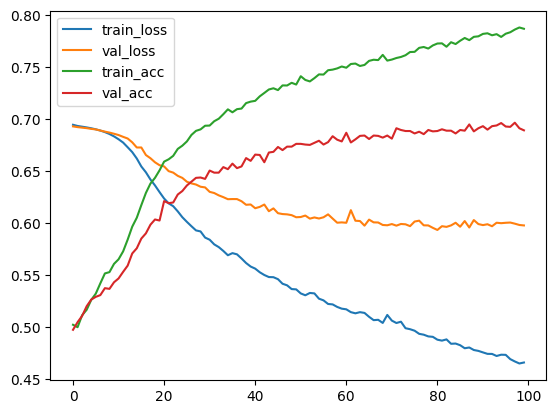

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})

df.plot()     # DataFrame 컬럼들을 한번에 라인 플롯으로 시각화
plt.show()